In [2]:
from db_utils import query_lutetium, get_time_limits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from ggplot import *
pd.options.display.mpl_style = 'default'
import numpy as np



#Data Acquisition

In [7]:
def get_contacts():


    query = """
    SELECT
    civicrm_contribution.total_amount,
    civicrm_country.iso_code,
    civicrm_contribution.receive_date,
    civicrm_email.email,
    civicrm_address.street_address,
    civicrm_address.postal_code,
    civicrm_address.city,
    civicrm_contact.first_name,
    civicrm_contact.last_name,
    contribution_tracking.utm_medium
    FROM
    civicrm.civicrm_contribution,
    civicrm.civicrm_address,
    civicrm.civicrm_country,
    civicrm.civicrm_email,
    civicrm.civicrm_contact,
    drupal.contribution_tracking
    
    WHERE 
    civicrm_contribution.id = drupal.contribution_tracking.contribution_id
    AND civicrm_contribution.contact_id = civicrm_address.contact_id
    AND civicrm_address.country_id = civicrm_country.id
    AND civicrm_contact.id = civicrm_contribution.contact_id
    AND civicrm_contribution.contact_id = civicrm_email.contact_id
    AND civicrm_address.is_primary = 1
    AND civicrm_country.iso_code = 'US'
    ORDER BY civicrm_contact.first_name;
    """
    #fraction_of_first_time_donors
    return query_lutetium(query, {})
    

In [4]:
d_orig = get_contacts()


In [8]:
d_orig['id'] = d_orig.index
print d_orig.shape

(5579679, 11)


In [5]:
d = d_orig

###Merging Donors by Email

In [10]:
# We first merge all contacts with the same email address
import numpy as np
def merge(d):
    d.id = d.id.min()
    return d
    
d = d.groupby('email').apply(merge)

In [11]:
print d.shape
print len(set(d.id))
d = d.fillna('')

(5579679, 11)
3792977


###Merging Donors by Address

In [15]:
def lower(s):
    try:
        return s.lower()
    except:
        return s

d['city'] = d['city'].apply(lower)
d['first_name'] = d['first_name'].apply(lower)
d['last_name'] = d['last_name'].apply(lower)
d['street_address'] = d['street_address'].apply(lower)


def map_street_abbreviations(s):
    try:
        s = s.replace('  ', ' ')
        s = s.replace('.', '')
        
        s = s.replace(' ct', ' court')
        s = s.replace(' street', ' st')
        s = s.replace(' str', ' st')
        s = s.replace(' boulevard', ' blvd')
        s = s.replace(' lane', ' ln')
        s = s.replace(' av', ' ave')
        s = s.replace(' avenue', ' ave')
        s = s.replace(' drive', ' dr')
        s = s.replace(' road', ' rd')
        return s
        
    except:
        return s
    
d['street_address'] = d['street_address'].apply(map_street_abbreviations)
d = d.groupby(['first_name', 'last_name','street_address', 'city' ]).apply(merge)
print d.shape
print len(set(d.id))

(5579679, 11)
3634867


In [ ]:
d.index = d.id
d['year'] = d['receive_date'].apply(lambda x: x.year)

In [40]:
d.to_csv('deduped_donors.csv')


In [14]:
gbo = d[['year', 'utm_medium']].groupby(['year', 'utm_medium'])
#pd.DataFrame(gbo.apply(lambda x: x.shape[0]))

In [2]:
d = pd.read_csv('deduped_donors.csv')

In [3]:
max_year = 2015
min_year = 2008
years = np.array(range(min_year, max_year))
donor_sets = { y:set(d[d.year == y].id) for y in years}
donors_per_year = np.array([float(len(donor_sets[i])) for i in years])

df = pd.DataFrame()
df['year'] = years
df['year'] = df['year'] -2000
df.index = df.year
df['donors_per_year'] = donors_per_year


# First Time vs Repeat Donors

In [4]:
fraction_of_first_time_donors = [1, ]
num_first_time_donors = [len(donor_sets[years[0]])]
num_repeat_donors = [0]
new_donors_dict = {min_year:donor_sets[min_year]}

for y in years[1:]:
    this_year = donor_sets[y]
    last_years = set(d[d.year < y].id)
    new_donors = this_year.difference(last_years)
    new_donors_dict[y] = new_donors
    repeat_donors = this_year.intersection(last_years)
    
    fraction_of_first_time_donors.append(len(new_donors)/float(len(this_year)))
    num_first_time_donors.append(len(new_donors))
    num_repeat_donors.append(len(repeat_donors))

In [5]:
df['fraction_of_first_time_donors'] = fraction_of_first_time_donors
df['num_first_time_donors'] = num_first_time_donors
df['num_repeat_donors'] = num_repeat_donors

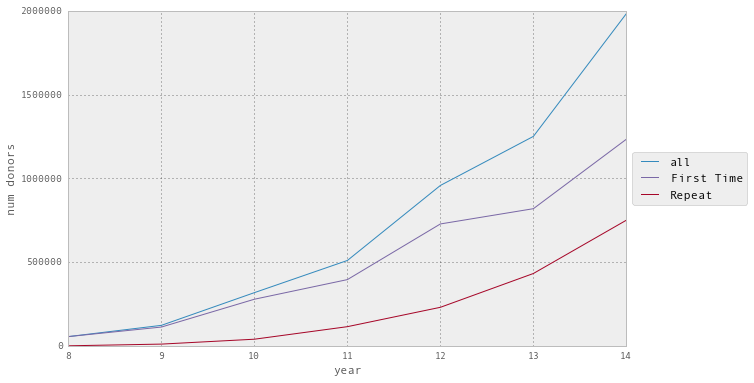

In [6]:
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(years-2000, donors_per_year, label = 'all')
plt.plot(years -2000, num_first_time_donors, label = 'First Time')
plt.plot(years -2000, num_repeat_donors, label = 'Repeat')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('year')
plt.ylabel('num donors')


###Explanation:
This plot shows the number of donors per year,  broken down by whether they are new donors.

###Interpretation:
- both populations are growing
- the number of repeat donors is growing more quickly
- we still have more first time donors than repeat donors (exaggerated by the difficulty of associating 2008 donors with 2014 donors)

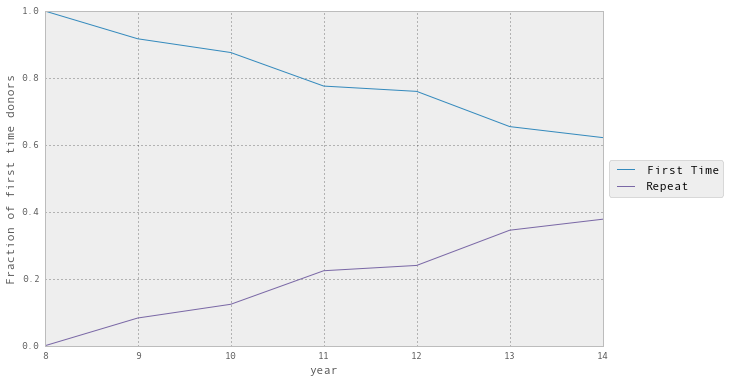

In [7]:
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(years -2000, fraction_of_first_time_donors, label = 'First Time')
plt.plot(years -2000, 1- np.array(fraction_of_first_time_donors), label = 'Repeat')

plt.xlabel('year')
plt.ylabel('Fraction of first time donors')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

###Explanation
This plot shows what fraction of donors are giving for the first time. For example, in 2013, we 65% of donors are new, meaning they did not give from 2008-2012.

###Interpetation
- this is a result of repeat donor population growing more quickly

#Donor Survival

In this next section, we will study the set of donors who did not give for the first time in 2014 (i.e. they gave in 2014 and in 2008-2013)

In [27]:
number_of_donors_giving_again_in_2014 = []
number_of_donors_giving_again_in_2014_via_email = []
number_of_donors_giving_again_in_2014_via_banner = []
number_of_email_donations = []

for y in years:
    
    repeat_donors = donor_sets[y].intersection(donor_sets[years[-1]])
    number_of_donors_giving_again_in_2014.append(float(len(repeat_donors)))
    
    d_repeat_donors = d[d['year'] == y]
    number_of_email_donations.append(d_repeat_donors.shape[0])

    
    d_repeat_donors = d_repeat_donors[d_repeat_donors['id'].isin(repeat_donors)]
    
    
    num_repeat_donors_email = float(len(set(d_repeat_donors[d_repeat_donors['utm_medium'] == 'email']['id'])))
    num_repeat_donors_banner = float(len(set(d_repeat_donors[d_repeat_donors['utm_medium'] == 'sitenotice']['id'])))
    number_of_donors_giving_again_in_2014_via_email.append(num_repeat_donors_email)
    number_of_donors_giving_again_in_2014_via_banner.append(num_repeat_donors_banner)
    
df['number_of_donors_giving_again_in_2014'] = number_of_donors_giving_again_in_2014
df['number_of_donors_giving_again_in_2014_via_email'] = number_of_donors_giving_again_in_2014_via_email
df['number_of_donors_giving_again_in_2014_via_banner'] = number_of_donors_giving_again_in_2014_via_banner

In [30]:
print number_of_email_donations
print np.array(number_of_donors_giving_again_in_2014_via_email).sum()

[63168, 138397, 346255, 528952, 1001594, 1346577, 2132090]
289491.0


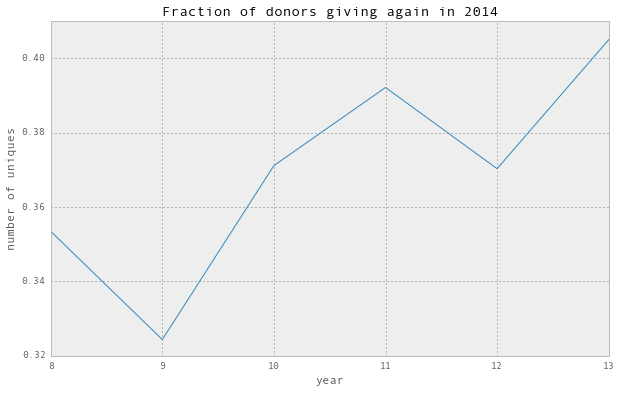

In [10]:
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(years[:-1] -2000,  number_of_donors_giving_again_in_2014[:-1] / donors_per_year[:-1])
plt.xlabel('year')
plt.ylabel('number of uniques')
plt.title("Fraction of donors giving again in 2014")

###Explanation
For each year, this plot shows the fraction of donors who donated again in 2014. For example, 35% of people who donated in 2008 donated again in 2014. Note: we may have trouble mapping 2008 donors to 2014 donors, which would lead our estimate to be low

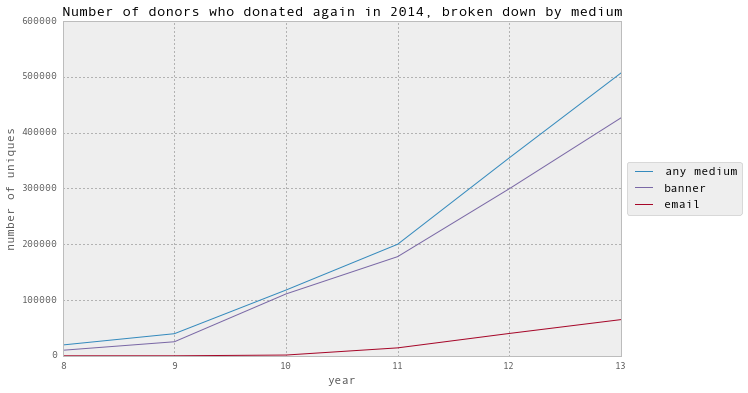

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(years[:-1] -2000, number_of_donors_giving_again_in_2014[:-1], label='any medium')
plt.plot(years[:-1] -2000, number_of_donors_giving_again_in_2014_via_banner[:-1], label='banner')
plt.plot(years[:-1] -2000, number_of_donors_giving_again_in_2014_via_email[:-1], label = 'email')
plt.title('Number of donors who donated again in 2014, broken down by medium')
plt.xlabel('year')
plt.ylabel('number of uniques')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

###Explanation
This plot shows the number donors for each year who donated again via email, a banner and any medium (including email and banner). Note: A donor who donated in 2009 may donate via email and banner in 2014. As such, adding the number of email and banner donors ( a subset of the media) may give a number that is larger than the number of unique repeat donors for that year.

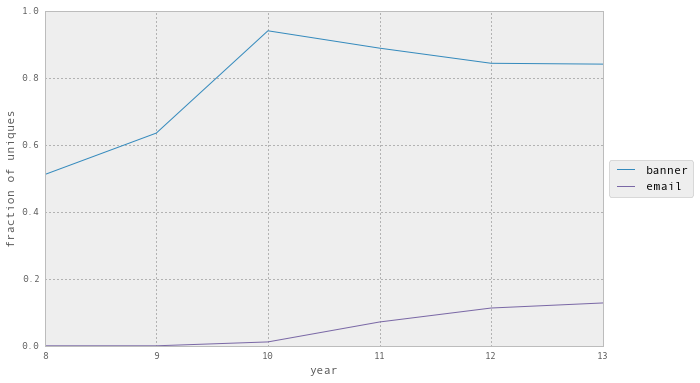

In [25]:
fig = plt.figure(figsize=(10, 6), dpi=80)
number_of_donors_giving_again_in_2014 = np.array(number_of_donors_giving_again_in_2014)
plt.plot(years[:-1] -2000, number_of_donors_giving_again_in_2014_via_banner[:-1]/number_of_donors_giving_again_in_2014[:-1], label='banner')
plt.plot(years[:-1] -2000, number_of_donors_giving_again_in_2014_via_email[:-1]/number_of_donors_giving_again_in_2014[:-1], label = 'email')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('year')
plt.ylabel('fraction of uniques')

###Explanation
This plot shows the number donors for each year who donated again via email and banner normalized by the number of repeat donors for the year. It looks like the naming convention for banner donations was different prior to 2010.

#How many times does a donor give?

In [267]:
distributions = {}
from collections import Counter

for start_year in years: 
    donors = new_donors_dict[start_year]
    cntr = Counter(donors)
    for year in years:
        if year <= start_year:
            continue
        repeat_donors = donor_sets[year].intersection(donors)
        cntr.update(repeat_donors)
    distributions[start_year] = Counter(cntr.values())
        
    
    
    
    

In [268]:
distributions[2008]

Counter({1: 19469, 2: 10460, 3: 8194, 4: 6437, 5: 5110, 6: 3602, 7: 1699})

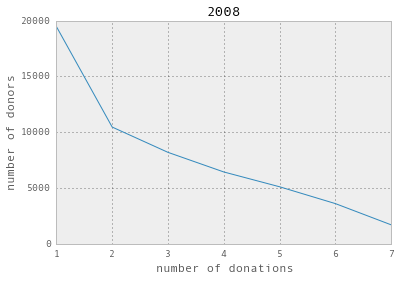

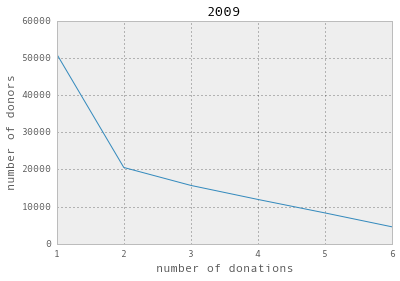

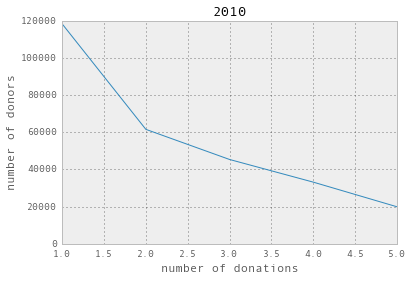

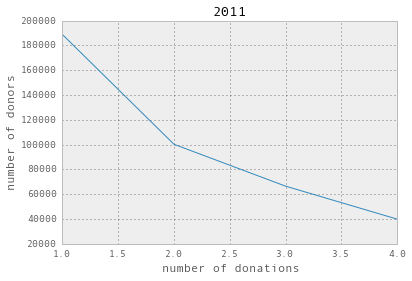

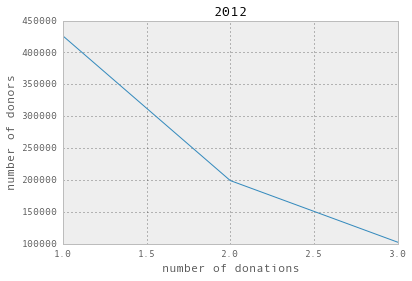

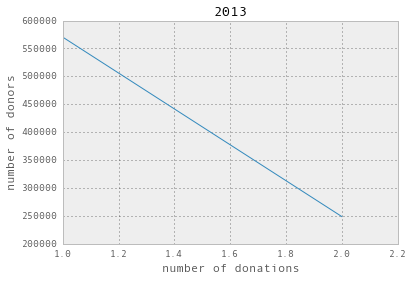

In [276]:
for year in years[:-1]:
    plt.figure()
    plt.plot(distributions[year].keys(), distributions[year].values())
    plt.xlabel('number of donations')
    plt.ylabel('number of donors')
    plt.title(year)